In [ ]:
!pip -q install vit_pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Pose.zip

In [ ]:
!unzip /content/gdrive/MyDrive/archive.zip

In [ ]:
!unzip /content/gdrive/MyDrive/Caso_1.zip

In [ ]:
import os
import shutil
import random

# Define the directories for your dataset
#dir1 = "/content/Caso_1/S1"
#dir2 = "/content/Caso_1/S2"
dir1 = "/content/Pose/lying"
dir2 = "/content/Pose/bending"
dir3 = "/content/Pose/sitting"
dir4 = "/content/Pose/standing"
#dir5 = "/content/Pose/walking"

# Define the output directories for train and test sets
train_dir = "/content/train_dir"
test_dir = "/content/test_dir"

# Define the size of your test set (as a percentage of the total number of images)
test_size = 0.2

# Create the train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each directory and copy its images to the train and test directories
for i, dir_path in enumerate([dir1, dir2, dir3, dir4]):#[dir1, dir2, dir3, dir4]  [dir1, dir2]

    # Get the list of image files in the directory
    file_list = os.listdir(dir_path)
    image_files = [os.path.join(dir_path, file_name) for file_name in file_list if file_name.endswith(".jpg") or file_name.endswith(".png")]

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Split the image files into train and test sets
    test_set_size = int(len(image_files) * test_size)
    train_set_size = len(image_files) - test_set_size
    train_set = image_files[:train_set_size]
    test_set = image_files[train_set_size:]

    # Copy the train set images to the train directory
    for file_path in train_set:
        file_name = os.path.basename(file_path)
        new_path = os.path.join(train_dir, f"{i+1}", file_name)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        shutil.copyfile(file_path, new_path)

    # Copy the test set images to the test directory
    for file_path in test_set:
        file_name = os.path.basename(file_path)
        new_path = os.path.join(test_dir, f"{i+1}", file_name)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        shutil.copyfile(file_path, new_path)

In [ ]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [ ]:
# Training settings
batch_size = 64#+64
epochs = 100
lr = 3e-5
gamma = 0.6
seed = 42
device = 'cuda'

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
train_dir = "/content/train_dir"
test_dir ="/content/test_dir"

train_list_1 = []
test_list_1 = []

# iterate over subdirectories in train_dir and add files to train_list
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith(".jpg") or file.endswith(".png"):
                train_list_1.append(os.path.join(subdir_path, file))

# iterate over subdirectories in test_dir and add files to test_list
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith(".jpg") or file.endswith(".png"):
                test_list_1.append(os.path.join(subdir_path, file))

# randomly shuffle train_list and test_list
random.shuffle(train_list_1)
random.shuffle(test_list_1)

In [ ]:
print(f"Train Data: {len(train_list_1)}")
print(f"Test Data: {len(test_list_1)}")

Train Data: 3840
Test Data: 960


In [ ]:
labels_1 = [path.split('/content/train_dir/')[-1].split('/')[0] for path in train_list_1]

In [ ]:
path='/content/test_dir/5/fb_002_064.png'
path.split('/content/test_dir/')[-1].split('/')[0]

'5'

In [ ]:
labels_1

In [ ]:
train_list_1, valid_list_1 = train_test_split(train_list_1,
                                          test_size=0.2,
                                          stratify=labels_1,
                                          random_state=seed)

In [ ]:
print(f"Train Data: {len(train_list_1)}")
print(f"Validation Data: {len(valid_list_1)}")
print(f"Test Data: {len(test_list_1)}")

Train Data: 3072
Validation Data: 768
Test Data: 960


In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [ ]:
class GEIDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        #print(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/content/train_dir/')[-1].split('/')[0]
        if (label =='1'):
          label=0
        if (label =='2'):
          label=1
        if (label =='3'):
          label=2
        if(label=='4'):
          label=3
        if(label=='5'):
          label=4

        return img_transformed,label

In [ ]:
class GEIDataset_val(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        #print(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/content/test_dir/')[-1].split('/')[0]
        if (label =='1'):
          label=0
        if (label =='2'):
          label=1
        if (label =='3'):
          label=2
        if(label=='4'):
          label=3
        if(label=='5'):
          label=4

        return img_transformed,label

In [ ]:
path='/content/test_dir_1/1/1014.jpg'
path.split('/content/test_dir_1/')[-1].split('/')[0]


'1'

In [ ]:
train_data_1 = GEIDataset(train_list_1, transform=train_transforms)
valid_data_1 = GEIDataset(train_list_1, transform=test_transforms)
test_data_1 = GEIDataset(train_list_1, transform=test_transforms)

In [ ]:
train_loader_1 = DataLoader(dataset = train_data_1, batch_size=batch_size, shuffle=True )
valid_loader_1 = DataLoader(dataset = valid_data_1, batch_size=batch_size, shuffle=True)
test_loader_1 = DataLoader(dataset = test_data_1, batch_size=batch_size, shuffle=True)

In [ ]:
efficient_transformer1 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
import cv2
img=cv2.imread('/content/train_dir/5/fb_002_061.png')
img.shape

(240, 320, 3)

In [ ]:
model1 = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=4,
    transformer=efficient_transformer1,
    channels=3,
).to(device)

In [ ]:
# loss function
criterion1 = nn.CrossEntropyLoss()
# optimizer
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
# scheduler
scheduler1 = StepLR(optimizer1, step_size=1, gamma=gamma)

In [ ]:
for data1, label1 in tqdm(train_loader_1):
        data1 = data1.to(device)
        label1 = label1.to(device)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
output1 = model1(data1)

In [ ]:
loss1 = criterion1(output1, label1)

In [ ]:
optimizer1.zero_grad()

In [ ]:
loss1.backward()

In [ ]:
optimizer1.step()

In [ ]:
for epoch in range(epochs):
    epoch_loss1 = 0
    epoch_accuracy1 = 0

    for data1, label1 in tqdm(train_loader_1):
        data1 = data1.to(device)
        label1 = label1.to(device)

        output1 = model1(data1)
        loss1 = criterion1(output1, label1)

        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        acc1 = (output1.argmax(dim=1) == label1).float().mean()
        epoch_accuracy1 += acc1 / len(train_loader_1)
        epoch_loss1 += loss1 / len(train_loader_1)

    with torch.no_grad():
        epoch_val_accuracy1 = 0
        epoch_val_loss1 = 0
        for data1, label1 in valid_loader_1:
            data1 = data1.to(device)
            label1 = label1.to(device)

            val_output1 = model1(data1)
            val_loss1 = criterion1(val_output1, label1)

            acc1 = (val_output1.argmax(dim=1) == label1).float().mean()
            epoch_val_accuracy1 += acc1 / len(valid_loader_1)
            epoch_val_loss1 += val_loss1 / len(valid_loader_1)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss1:.4f} - acc: {epoch_accuracy1:.4f} - val_loss : {epoch_val_loss1:.4f} - val_acc: {epoch_val_accuracy1:.4f}\n"
    )

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.3832 - acc: 0.2786 - val_loss : 1.3394 - val_acc: 0.5049



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.3533 - acc: 0.3535 - val_loss : 1.2621 - val_acc: 0.5638



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.2863 - acc: 0.4095 - val_loss : 1.0714 - val_acc: 0.5381



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.2084 - acc: 0.4313 - val_loss : 0.9596 - val_acc: 0.6035



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.1549 - acc: 0.4658 - val_loss : 0.9025 - val_acc: 0.6722



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.0767 - acc: 0.5091 - val_loss : 0.8286 - val_acc: 0.6803



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.0066 - acc: 0.5667 - val_loss : 0.7752 - val_acc: 0.7142



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.9415 - acc: 0.5967 - val_loss : 0.7272 - val_acc: 0.7168



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.9546 - acc: 0.5996 - val_loss : 0.7009 - val_acc: 0.7679



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.9069 - acc: 0.6257 - val_loss : 0.6638 - val_acc: 0.7549



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.8746 - acc: 0.6354 - val_loss : 0.6438 - val_acc: 0.7845



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.8768 - acc: 0.6523 - val_loss : 0.6513 - val_acc: 0.7744



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.8759 - acc: 0.6471 - val_loss : 0.6503 - val_acc: 0.7601



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.8482 - acc: 0.6579 - val_loss : 0.5974 - val_acc: 0.8014



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.8504 - acc: 0.6562 - val_loss : 0.5944 - val_acc: 0.7972



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.8206 - acc: 0.6647 - val_loss : 0.5719 - val_acc: 0.8148



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.8390 - acc: 0.6663 - val_loss : 0.5562 - val_acc: 0.8184



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.8273 - acc: 0.6725 - val_loss : 0.5570 - val_acc: 0.8096



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.8024 - acc: 0.6872 - val_loss : 0.5352 - val_acc: 0.8249



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.7954 - acc: 0.6797 - val_loss : 0.5367 - val_acc: 0.8268



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.7889 - acc: 0.6823 - val_loss : 0.5042 - val_acc: 0.8350



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.7522 - acc: 0.7041 - val_loss : 0.5134 - val_acc: 0.8239



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.7743 - acc: 0.6872 - val_loss : 0.5121 - val_acc: 0.8317



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.7631 - acc: 0.6927 - val_loss : 0.5211 - val_acc: 0.8105



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.7604 - acc: 0.6921 - val_loss : 0.5106 - val_acc: 0.8382



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.7546 - acc: 0.6960 - val_loss : 0.4769 - val_acc: 0.8398



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.7721 - acc: 0.6833 - val_loss : 0.4758 - val_acc: 0.8434



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.7273 - acc: 0.7109 - val_loss : 0.4667 - val_acc: 0.8415



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.7448 - acc: 0.7116 - val_loss : 0.4590 - val_acc: 0.8503



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.7173 - acc: 0.7139 - val_loss : 0.4628 - val_acc: 0.8551



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.7299 - acc: 0.7074 - val_loss : 0.4464 - val_acc: 0.8506



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.7277 - acc: 0.7070 - val_loss : 0.4728 - val_acc: 0.8441



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.7545 - acc: 0.7041 - val_loss : 0.4591 - val_acc: 0.8516



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.7067 - acc: 0.7285 - val_loss : 0.4387 - val_acc: 0.8542



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.7002 - acc: 0.7240 - val_loss : 0.4335 - val_acc: 0.8568



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.7030 - acc: 0.7214 - val_loss : 0.4540 - val_acc: 0.8506



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.7132 - acc: 0.7152 - val_loss : 0.4240 - val_acc: 0.8633



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6731 - acc: 0.7308 - val_loss : 0.4293 - val_acc: 0.8568



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6970 - acc: 0.7240 - val_loss : 0.4235 - val_acc: 0.8617



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.7153 - acc: 0.7194 - val_loss : 0.4536 - val_acc: 0.8424



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6861 - acc: 0.7373 - val_loss : 0.4250 - val_acc: 0.8577



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.6820 - acc: 0.7308 - val_loss : 0.4190 - val_acc: 0.8620



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6751 - acc: 0.7386 - val_loss : 0.4120 - val_acc: 0.8620



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6879 - acc: 0.7370 - val_loss : 0.4198 - val_acc: 0.8542



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6793 - acc: 0.7471 - val_loss : 0.4632 - val_acc: 0.8343



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.6730 - acc: 0.7380 - val_loss : 0.4205 - val_acc: 0.8532



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6732 - acc: 0.7389 - val_loss : 0.4300 - val_acc: 0.8525



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.6696 - acc: 0.7389 - val_loss : 0.3952 - val_acc: 0.8675



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.6645 - acc: 0.7432 - val_loss : 0.3911 - val_acc: 0.8730



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.6494 - acc: 0.7480 - val_loss : 0.3773 - val_acc: 0.8786



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.6574 - acc: 0.7425 - val_loss : 0.3759 - val_acc: 0.8786



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.6404 - acc: 0.7516 - val_loss : 0.3957 - val_acc: 0.8753



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.6664 - acc: 0.7380 - val_loss : 0.3815 - val_acc: 0.8779



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.6478 - acc: 0.7546 - val_loss : 0.3904 - val_acc: 0.8750



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.6485 - acc: 0.7523 - val_loss : 0.3854 - val_acc: 0.8763



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.6473 - acc: 0.7435 - val_loss : 0.3938 - val_acc: 0.8724



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.6485 - acc: 0.7484 - val_loss : 0.3681 - val_acc: 0.8809



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.6390 - acc: 0.7510 - val_loss : 0.3497 - val_acc: 0.8828



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.6217 - acc: 0.7601 - val_loss : 0.3461 - val_acc: 0.8848



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.6248 - acc: 0.7581 - val_loss : 0.3633 - val_acc: 0.8874



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.6450 - acc: 0.7503 - val_loss : 0.3641 - val_acc: 0.8789



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.6334 - acc: 0.7565 - val_loss : 0.3676 - val_acc: 0.8805



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.6443 - acc: 0.7539 - val_loss : 0.3693 - val_acc: 0.8802



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.6028 - acc: 0.7692 - val_loss : 0.3530 - val_acc: 0.8932



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.6404 - acc: 0.7526 - val_loss : 0.3434 - val_acc: 0.8883



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.6397 - acc: 0.7513 - val_loss : 0.3857 - val_acc: 0.8783



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.6198 - acc: 0.7565 - val_loss : 0.3447 - val_acc: 0.8877



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.6312 - acc: 0.7604 - val_loss : 0.3361 - val_acc: 0.8945



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.6020 - acc: 0.7673 - val_loss : 0.3447 - val_acc: 0.8929



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.6113 - acc: 0.7650 - val_loss : 0.3557 - val_acc: 0.8809



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.6212 - acc: 0.7575 - val_loss : 0.3354 - val_acc: 0.8926



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.6341 - acc: 0.7542 - val_loss : 0.3763 - val_acc: 0.8724



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.6140 - acc: 0.7699 - val_loss : 0.3464 - val_acc: 0.8870



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.6018 - acc: 0.7669 - val_loss : 0.3419 - val_acc: 0.8887



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.6070 - acc: 0.7640 - val_loss : 0.3560 - val_acc: 0.8815



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.6079 - acc: 0.7604 - val_loss : 0.3276 - val_acc: 0.8984



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.6180 - acc: 0.7643 - val_loss : 0.3332 - val_acc: 0.8949



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.6087 - acc: 0.7689 - val_loss : 0.3188 - val_acc: 0.8984



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.6143 - acc: 0.7598 - val_loss : 0.3715 - val_acc: 0.8760



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.6018 - acc: 0.7757 - val_loss : 0.3323 - val_acc: 0.8968



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.6088 - acc: 0.7676 - val_loss : 0.3407 - val_acc: 0.8923



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.6023 - acc: 0.7803 - val_loss : 0.3458 - val_acc: 0.8910



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.6109 - acc: 0.7663 - val_loss : 0.3330 - val_acc: 0.8916



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.5961 - acc: 0.7699 - val_loss : 0.3037 - val_acc: 0.8997



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.6094 - acc: 0.7692 - val_loss : 0.3241 - val_acc: 0.8906



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.5721 - acc: 0.7822 - val_loss : 0.3083 - val_acc: 0.8949



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.6074 - acc: 0.7637 - val_loss : 0.3468 - val_acc: 0.8926



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.6011 - acc: 0.7712 - val_loss : 0.3227 - val_acc: 0.8900



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.5944 - acc: 0.7796 - val_loss : 0.3172 - val_acc: 0.9007



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.5825 - acc: 0.7904 - val_loss : 0.3244 - val_acc: 0.8939



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.5847 - acc: 0.7826 - val_loss : 0.3045 - val_acc: 0.9069



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.6077 - acc: 0.7695 - val_loss : 0.3715 - val_acc: 0.8698



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.5718 - acc: 0.7868 - val_loss : 0.2918 - val_acc: 0.9043



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.5884 - acc: 0.7773 - val_loss : 0.3091 - val_acc: 0.9007



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.5798 - acc: 0.7770 - val_loss : 0.3129 - val_acc: 0.8965



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.5753 - acc: 0.7786 - val_loss : 0.3039 - val_acc: 0.9004



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.5786 - acc: 0.7734 - val_loss : 0.3048 - val_acc: 0.9036



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.5750 - acc: 0.7913 - val_loss : 0.3093 - val_acc: 0.8939



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.5755 - acc: 0.7793 - val_loss : 0.3065 - val_acc: 0.9014



  0%|          | 0/48 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.5745 - acc: 0.7826 - val_loss : 0.3156 - val_acc: 0.8949



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

with torch.no_grad():
    input_tensor = val_transforms(Image.open('/content/test_dir/3/1009.jpg').convert('RGB')).unsqueeze(0).to(device)
    outputs = model1(input_tensor)
    predicted_probs = torch.nn.functional.softmax(outputs[0], dim=0)

In [ ]:
tensor_cpu = predicted_probs.cpu()
print(tensor_cpu.numpy()[0])
print(tensor_cpu.numpy()[1])
print(tensor_cpu.numpy()[2])
print(tensor_cpu.numpy()[3])

0.013588262
0.027650084
0.7997606
0.15900107


**Confusion Matrix**

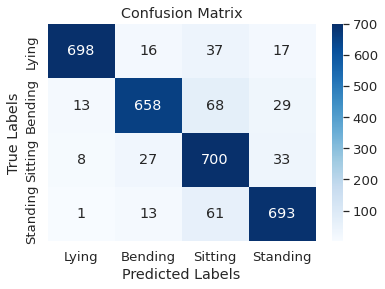

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
model1.eval()

label_map = {0: 'Lying', 1: 'Bending', 2: 'Sitting', 3: 'Standing'}

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader_1:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

# Plot confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

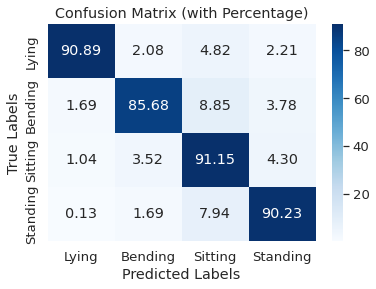

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)
model1.eval()

label_map = {0: 'Lying', 1: 'Bending', 2: 'Sitting', 3: 'Standing'}

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in valid_loader_1:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

# Calculate confusion matrix percentage
cm_percent = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100, 2)

# Plot confusion matrix with percentage
sns.set(font_scale=1.2)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (with Percentage)')
plt.show()

In [ ]:
!pip install onnx

In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 11.4 MB/s eta 0:00:00


In [ ]:
import onnx

# create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224)

# set the input and output names for the ONNX model
input_names = ['input']
output_names = ['output']

# move the model to the same device as the dummy input
model1.to(dummy_input.device)

# export the model to ONNX format
onnx_filename = 'vit_HP2.onnx'

try:
    torch.onnx.export(model1, dummy_input, onnx_filename, input_names=input_names, output_names=output_names)
    print(f"Model successfully exported to ONNX format: {onnx_filename}")
except RuntimeError as error:
    print(f"Error occurred while exporting the model: {error}")

/usr/local/lib/python3.9/dist-packages/linformer/linformer.py:97: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert kv_len == self.seq_len, f'the sequence length of the key / values must be {self.seq_len} - {kv_len} given'


Model successfully exported to ONNX format: vit_HP2.onnx


Predicted class: Standing


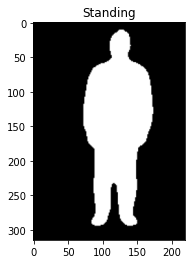

In [ ]:
import onnxruntime as ort

path_test='/content/test_22.png'
img = Image.open(path_test)
img=ImageOps.invert(img)

# apply image transforms
img = val_transforms(img)

# convert the transformed image to a NumPy array
img_np = np.array(img).astype(np.float32)
img_np = np.expand_dims(img_np, axis=0)

session = ort.InferenceSession('/content/vit_HP2.onnx')
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
result = session.run([output_name], {input_name: img_np})

# print the predicted class label
class_index = np.argmax(result[0])
class_labels = ['Lying', 'Bending','Sitting','Standing'] # replace with your own labels
print('Predicted class:', class_labels[class_index])

image = Image.open(path_test).convert("L")
arr = 255-np.asarray(image)
plt.title(class_labels[class_index])
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()